# Templates (16-08-28)

## Goals

- The main point of this ipynb is to get working versions of the import function working and to get some generic imports working as well.

## Summary

Still a work in progress.

# Preliminaries

## Globals and Imports

In [2]:
date = "160828"  
directory = "//Andor/share/Data and documents/Data repository/" + date + "/"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit as fit
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
%matplotlib inline

## Set Matplotlib defaults

In [3]:
# set matplotlib plot defaults :D
# These values are nice for a dark theme.
mpl.rcParams['text.color'] = '#ffffff'
mpl.rcParams['figure.edgecolor'] = '#ffffff'
mpl.rcParams['xtick.color'] = '#ffffff'
mpl.rcParams['ytick.color'] = '#ffffff'
mpl.rcParams['figure.facecolor'] = '#000000'
mpl.rcParams['axes.facecolor'] = '#0a0a0a'
mpl.rcParams['figure.figsize'] = (18.0, 8.0)
mpl.rcParams['axes.labelcolor'] = '#ffffff'
mpl.rcParams['grid.color'] = '#aaaaff'
mpl.rcParams['axes.edgecolor'] = '#ffffff'
mpl.rcParams['legend.facecolor'] = '#0a0a0a'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.formatter.useoffset'] = False

## Fitting Functions

In [48]:
# Fits 
def quadratic(x,a,b,x0):
    # This assumes downward facing. Best to write another function for upward facing if need be, I think.
    if a < 0:
        return 10**10
    if b > 0:
        return 10**10
    return a + b*(x-x0)**2


def gaussian(x, A1, x01, sig1, offset):
    if (offset < 0):
        return 10**10
    return offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2))


def doubleGaussian(x, A1, x01, sig1, A2, x02, sig2, offset):
    if (A1 < 0 or A2 < 0):
        # Penalize negative fits.
        return 10**10
    if (offset < 0):
        return 10**10
    return offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2)) + A2 * np.exp(-(x-x02)**2/(2*sig2**2))


def tripleGaussian(x, A1, x01, sig1, A2, x02, sig2, A3, x03, sig3, offset ):
    if (A1 < 0 or A2 < 0 or A3 < 0):
        # Penalize negative fits.
        return 10**10
    if (offset < 0):
        return 10**10
    return (offset + A1 * np.exp(-(x-x01)**2/(2*sig1**2)) + A2 * np.exp(-(x-x02)**2/(2*sig2**2)) 
            + A3 * np.exp(-(x-x03)**2/(2*sig3**2)))        


def decayingCos(x, A, tau, f, phi, offset):
    if (A < 0):
        return 10**10
    # Just for sanity. Keep it positive.
    if (phi < 0):
        return 10**10
    if (offset < 0):
        return 10**10
    # no growing fits.
    if (tau > 0):
        return 10**10
    return offset + A * np.exp(-x/tau) * np.cos(2 * np.pi * f * x + phi)


def sinc_squared(x, A, center, scale, offset):
    if (offset < 0):
        return x * 10**10
    if (A < 0):
        return x * 10**10
    return (A * np.sinc(scale*(x - center))**2 + offset)


def lorentzian(x, A, center, width, offset):
    if (offset < 0):
        return x * 10**10
    if (A < 0):
        return x * 10**10
    return (A /((x - center)**2 + (width/2)**2))


def poissonian(x, k, weight):    
    """
    This function calculates p_k{x} = weight * e^(-k) * k^x / x!.
    :param x: argument of the poissonian
    :param k: order or (approximate) mean of the poissonian.
    :param weight: a weight factor, related to the maximum data this is supposed to be fitted to, but typically over-
    weighted for the purposes of this function.
    :return: the poissonian evaluated at x given the parametes.
    """
    import numpy as np
    term = 1
    # calculate the term k^x / x!. Can't do this directly, x! is too large.
    for n in range(0, int(x)):
        term *= k / (x - n)
    return np.exp(-k) * term * weight


In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Import Data Function

In [6]:
def importData(date, name, runNumber):
    """
    This function imports the data created by my first-step python code.
    :param date: the date in YYMMDD format so that the code knows where to look for the data.
    :param name: the name of the compiled data file, minus _run?? (e.g. it's standardized for carrier calibrations
    :param runNumber: The run number.
    :return: returns an OrderedDictionary object from the collections library that contains all the information about
             a run.
    """
    from collections import OrderedDict as dic
    data = dic()
    with open('//andor/share/Data and documents/Data repository/' + str(date) + '/' + str(name) + '_run'
              + str(runNumber) + '.csv') as myfile:
        fileText = myfile.read().replace('\n', '')
        rows = []
        for row in fileText.split(':'):
            rows.append(row.replace('\t', ''))
        del rows[0]
        for itemInc in range(0, len(rows), 2):
            if (rows[itemInc + 1].find(';')) != -1:
                itemData = dic()
                subrows = []
                for subrow in rows[itemInc + 1].split(';'):
                    subrows.append(subrow)
                del subrows[0]
                for subitem in range(0, len(subrows), 2):
                    try:
                        itemData[subrows[subitem]] = [float(item) for item in (subrows[subitem + 1].split(','))]
                    except:
                        itemData[subrows[subitem]] = subrows[subitem + 1].split(',')

                data[rows[itemInc]] = itemData
            else:
                try:
                    data[rows[itemInc]] = [float(item) for item in (rows[itemInc + 1].split(','))]
                except:
                    data[rows[itemInc]] = rows[itemInc + 1].split(',')
    return data


## Markdown Reminders

Markdown | Table | Example
--- | :---: | ---:
*It* | `renders` | **nicely**
~~1~~ | 2 | 3

```str hello = 'world'
errBox("not an *error*")
return FALSE;```

> what is going
> on

---

- Lists
+ Are
* Fun  


***

1.  stuff
  * Unordered sub-list.
1000. Actual numbers don't matter, just that it's a number
+ I lied, just the first bullet for a given list determines the type.
  1. Ordered sub-list  
    hey.
    2. what?

___

html and links are also possible.

## Usage Notes

Current Base Key Strings (data['???']):  
- Key List
- Date
- Run Number
- Repetitions
- Pictures Per Experiment
- Key
- < Atom Locations >
- Correlation Averages
- Correlation Errors

Current Atom Key Strings (e.g. data['[3, 1]']['???'])
- Key List
- Survival Averages
- Survival Errors
- Loading Probabilities
- Atom Location
- Threshold
- Threshold Fidelity
- Atoms Data

Current Multi-Atom Key Strings (e.g. data['[Correlation Averages]']['???'])
- Load < 1-max >, atom < 0-max-1 > survived
- Load < 1-max >, < 0-max > atoms survived
- Load < 1-max >, average single atom survival
- Total average single atom survival

Similar for Multi-Atom Errors.

# Generic Single-Atom Data Analysis

## Generic No-Fit

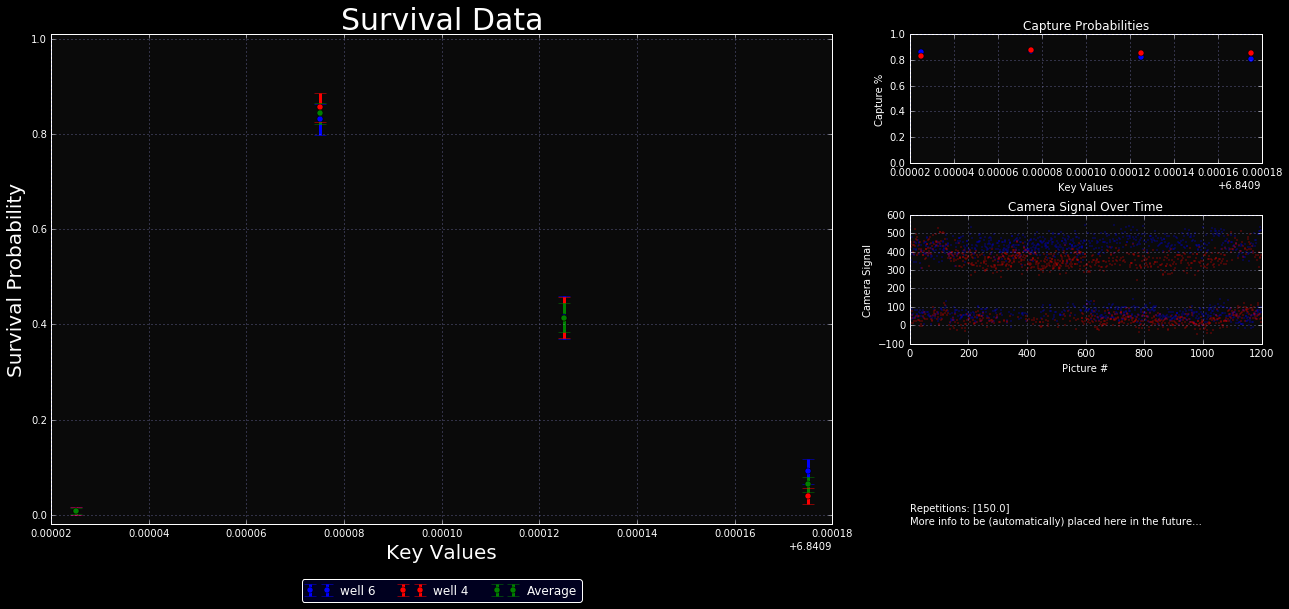

In [83]:
filename = "Carrier_Calibration_Top_Vert"
# DATA ANALYSIS
data = importData(date, filename, 11) # stands for "data from run 11"
loc1 = '[3, 1]'
loc2 = '[5, 1]'
# Main Plot
mainPlot = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
mainPlot.errorbar(data['Key'], data[loc2]['Survival Averages'], yerr=data[loc2]['Survival Errors'],
                  ls='', marker='o', label="well 6", color='b', capsize=6,
                  elinewidth=3)#
mainPlot.errorbar(data['Key'], data[loc1]['Survival Averages'], yerr=data[loc1]['Survival Errors'],
                  ls='', marker='o', label="well 4", color='r', capsize=6, elinewidth=3)
mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                  yerr=data['[Correlation Errors]']['Total average single atom survival'],
                  ls='', marker='o', label="Average", color='g', capsize=6, elinewidth=3)
mainPlot.set_ylim({-0.02, 1.01});
mainPlot.set_title("Survival Data", fontsize=30);
mainPlot.set_ylabel("Survival Probability", fontsize=20);
mainPlot.set_xlabel("Key Values", fontsize=20);
mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4);
mainPlot.grid("on")
# Capture Probabilities Plot
capturePlot = plt.subplot2grid((3, 3), (0, 2))
capturePlot.plot(data['Key'], data[loc2]['Loading Probabilities'], ls='', marker='o', color='b')
capturePlot.plot(data['Key'], data[loc1]['Loading Probabilities'], ls='', marker='o', color='r')
capturePlot.set_ylim({0, 1})
capturePlot.set_xlabel("Key Values")
capturePlot.set_ylabel("Capture %")
capturePlot.set_title("Capture Probabilities")
capturePlot.grid("on")
# Count Series Plot
countDataPlot = plt.subplot2grid((3, 3), (1, 2))
countDataPlot.plot(data[loc2]['Data Counts'], 'b', ls='', marker='.', markersize=1)
countDataPlot.plot(data[loc1]['Data Counts'], 'r', ls='', marker='.', markersize=1)
countDataPlot.set_xlabel("Picture #")
countDataPlot.set_ylabel("Camera Signal")
countDataPlot.set_title("Camera Signal Over Time")
countDataPlot.grid("on")
# info plot
infoPlot = plt.subplot2grid((3,3), (2,2))
infoPlot.axis("off")
infoPlot.text(0,0, "More info to be (automatically) placed here in the future...")
infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
plt.tight_layout();

## Generic Quadradic Fit

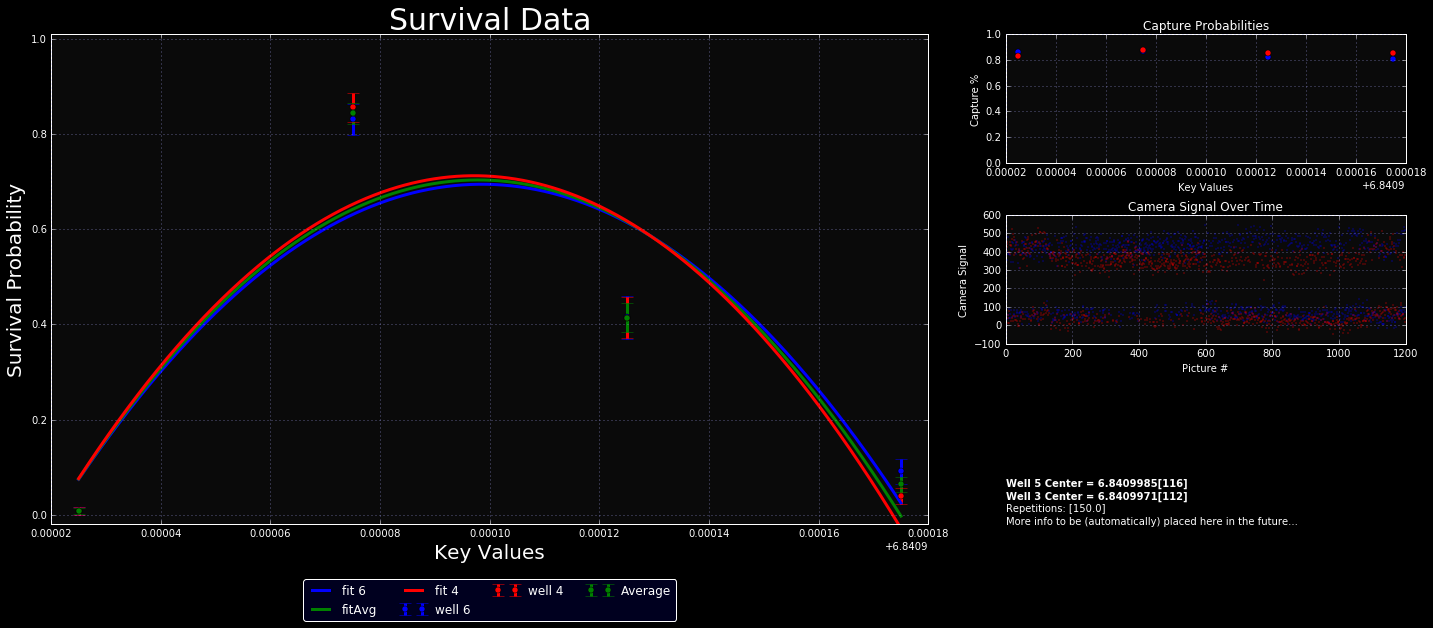

In [69]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 11) # stands for "data from run 11"
loc1 = '[3, 1]'
loc2 = '[5, 1]'
# Fit Data
data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
likelyCenter1 = data['Key'][data[loc2]['Survival Averages'].index(max(data[loc2]['Survival Averages']))]
widthGuess = - 1 / np.std(data['Key']) # assumes downward facing.
data[loc2]['fitValues'], data[loc2]['covValues'] = fit(quadratic, data['Key'], data[loc2]['Survival Averages'], 
                                                        p0=[0.95, widthGuess, likelyCenter1])
data[loc2]['fitData'] = quadratic(data['xForFit'], *data[loc2]['fitValues']);

likelyCenter2 = data['Key'][data[loc1]['Survival Averages'].index(max(data[loc1]['Survival Averages']))]
data[loc1]['fitValues'], data[loc1]['covValues']  = fit(quadratic, data['Key'], data[loc1]['Survival Averages'],
                                                         p0=[0.95, widthGuess, likelyCenter2])
data[loc1]['fitData'] = quadratic(data['xForFit'], *data[loc1]['fitValues'])
likelyCenterAvg = (likelyCenter2 + likelyCenter1) / 2
data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
    = fit(quadratic, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
          p0=[1, widthGuess, likelyCenter2])
data['[Correlation Averages]']['fitData'] = quadratic(data['xForFit'], *data['[Correlation Averages]']['fitValues'])
                                       
# Main Plot
#myFig = plt.figure(1, figsize=(20, 8))
mainPlot = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
mainPlot.errorbar(data['Key'], data[loc2]['Survival Averages'], yerr=data[loc2]['Survival Errors'],
                  ls='', marker='o', label="well 6", color='b', capsize=6,
                  elinewidth=3)
mainPlot.plot(data['xForFit'], data[loc2]['fitData'], color='b', label='fit 6', linewidth=3)
#
mainPlot.errorbar(data['Key'], data[loc1]['Survival Averages'], yerr=data[loc1]['Survival Errors'],
                  ls='', marker='o', label="well 4", color='r', capsize=6, elinewidth=3)
mainPlot.plot(data['xForFit'], data['[Correlation Averages]']['fitData'], color='g', label='fitAvg', linewidth=3)                                       
mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                  yerr=data['[Correlation Errors]']['Total average single atom survival'],
                  ls='', marker='o', label="Average", color='g', capsize=6, elinewidth=3)
mainPlot.plot(data['xForFit'], data[loc1]['fitData'], color='r', label='fit 4', linewidth=3)
mainPlot.set_ylim({-0.02, 1.01});
mainPlot.set_title("Survival Data", fontsize=30);
mainPlot.set_ylabel("Survival Probability", fontsize=20);
mainPlot.set_xlabel("Key Values", fontsize=20);
mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4);
mainPlot.grid("on")
# Capture Probabilities Plot
capturePlot = plt.subplot2grid((3, 3), (0, 2))
capturePlot.plot(data['Key'], data[loc2]['Loading Probabilities'], ls='', marker='o', color='b')
capturePlot.plot(data['Key'], data[loc1]['Loading Probabilities'], ls='', marker='o', color='r')
capturePlot.set_ylim({0, 1})
capturePlot.set_xlabel("Key Values")
capturePlot.set_ylabel("Capture %")
capturePlot.set_title("Capture Probabilities")
capturePlot.grid("on")
# Count Series Plot
countDataPlot = plt.subplot2grid((3, 3), (1, 2))
countDataPlot.plot(data[loc2]['Data Counts'], 'b', ls='', marker='.', markersize=1)
countDataPlot.plot(data[loc1]['Data Counts'], 'r', ls='', marker='.', markersize=1)
countDataPlot.set_xlabel("Picture #")
countDataPlot.set_ylabel("Camera Signal")
countDataPlot.set_title("Camera Signal Over Time")
countDataPlot.grid("on")
# info plot
infoPlot = plt.subplot2grid((3,3), (2,2))
infoPlot.axis("off")
infoPlot.text(0,0, "More info to be (automatically) placed here in the future...")
infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
infoPlot.text(0,0.2,"Well 3 Center = " + "{:.7f}".format(data[loc1]['fitValues'][2]) + "[" 
              + "{:.0f}".format(10**7*np.sqrt(data[loc1]['covValues'][2][2])) + "]", fontweight='bold')
infoPlot.text(0,0.3,"Well 5 Center = " + "{:.7f}".format(data[loc2]['fitValues'][2]) + "[" 
              + "{:.0f}".format(10**7*np.sqrt(data[loc2]['covValues'][2][2])) + "]", fontweight='bold')
plt.tight_layout();

## Generic $\text{sinc}^2\{x\}$ Fit

[  9.48518859e-01   6.84099188e+00   1.44800833e+04   1.89446118e-02]


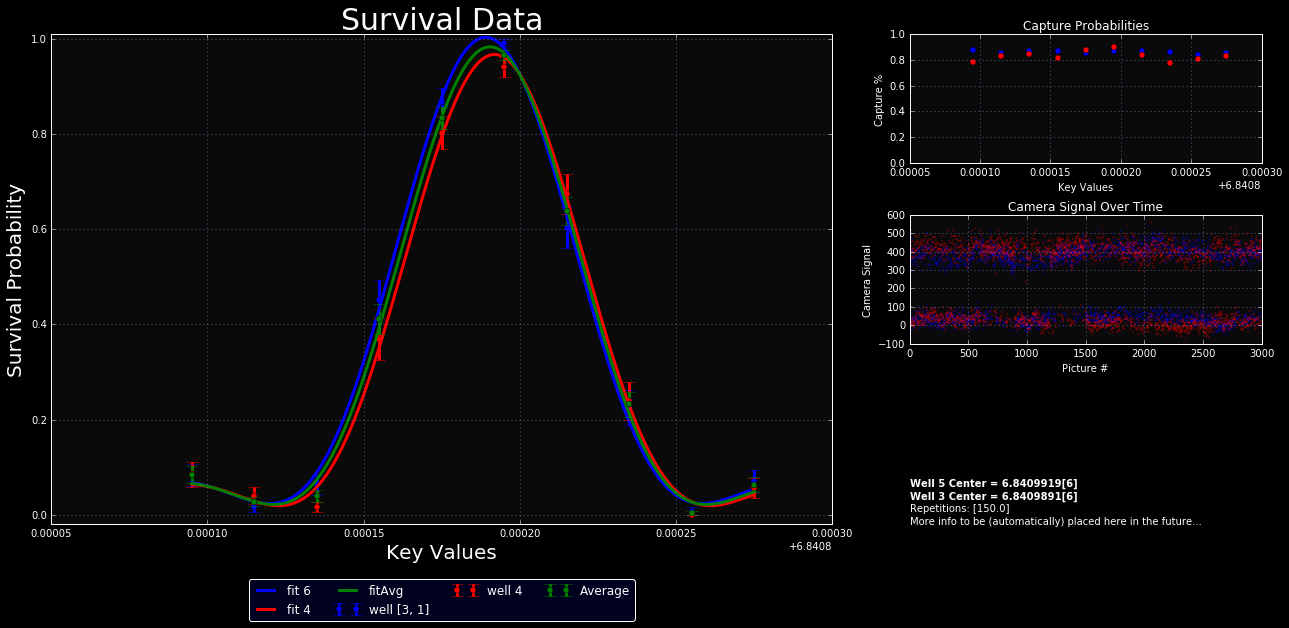

In [80]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 12) # stands for "data from run 11"
locs = ['[3, 1]', '[5, 1]']
# fit
data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
likelyCenter1 = data['Key'][data[locs[0]]['Survival Averages'].index(max(data[locs[0]]['Survival Averages']))]
widthGuess = 0.5 / np.std(data['Key']) # assumes downward facing.
# def sinc_squared(x, A, center, scale, offset):
data[locs[0]]['fitValues'], data[locs[0]]['covValues'] = fit(sinc_squared, data['Key'], 
                                                             data[locs[0]]['Survival Averages'], 
                                                             p0=[0.95, likelyCenter1, widthGuess, 0.05])
data[locs[0]]['fitData'] = sinc_squared(data['xForFit'], *data[locs[0]]['fitValues']);

likelyCenter2 = data['Key'][data[locs[1]]['Survival Averages'].index(max(data[locs[1]]['Survival Averages']))]
data[locs[1]]['fitValues'], data[locs[1]]['covValues']  = fit(sinc_squared, data['Key'], 
                                                              data[locs[1]]['Survival Averages'],
                                        p0=[0.95, likelyCenter2, widthGuess, 0.05])
data[locs[1]]['fitData'] = sinc_squared(data['xForFit'], *data[locs[1]]['fitValues'])
likelyCenterAvg = (likelyCenter2 + likelyCenter1) / 2
data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
    = fit(sinc_squared, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
          p0=[0.95, likelyCenterAvg, widthGuess, 0.05])
data['[Correlation Averages]']['fitData'] = sinc_squared(data['xForFit'], *data['[Correlation Averages]']['fitValues'])
                                       
# Main Plot
mainPlot = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
mainPlot.errorbar(data['Key'], data[locs[0]]['Survival Averages'], yerr=data[locs[0]]['Survival Errors'],
                  ls='', marker='o', label="well " + locs[0], color='b', capsize=6,
                  elinewidth=3)
mainPlot.plot(data['xForFit'], data[locs[0]]['fitData'], color='b', label='fit 6', linewidth=3)
#
mainPlot.errorbar(data['Key'], data[locs[1]]['Survival Averages'], yerr=data[locs[1]]['Survival Errors'],
                  ls='', marker='o', label="well 4", color='r', capsize=6, elinewidth=3)
mainPlot.plot(data['xForFit'], data[locs[1]]['fitData'], color='r', label='fit 4', linewidth=3)
#
mainPlot.plot(data['xForFit'], data['[Correlation Averages]']['fitData'], color='g', label='fitAvg', linewidth=3)                                       
mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                  yerr=data['[Correlation Errors]']['Total average single atom survival'],
                  ls='', marker='o', label="Average", color='g', capsize=6, elinewidth=3)

mainPlot.set_ylim({-0.02, 1.01});
mainPlot.set_title("Survival Data", fontsize=30);
mainPlot.set_ylabel("Survival Probability", fontsize=20);
mainPlot.set_xlabel("Key Values", fontsize=20);
mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4);
mainPlot.grid("on")
# Capture Probabilities Plot
capturePlot = plt.subplot2grid((3, 3), (0, 2))
capturePlot.plot(data['Key'], data[locs[0]]['Loading Probabilities'], ls='', marker='o', color='b')
capturePlot.plot(data['Key'], data[locs[1]]['Loading Probabilities'], ls='', marker='o', color='r')
capturePlot.set_ylim({0, 1})
capturePlot.set_xlabel("Key Values")
capturePlot.set_ylabel("Capture %")
capturePlot.set_title("Capture Probabilities")
capturePlot.grid("on")
# Count Series Plot
countDataPlot = plt.subplot2grid((3, 3), (1, 2))
countDataPlot.plot(data[locs[0]]['Data Counts'], 'b', ls='', marker='.', markersize=1)
countDataPlot.plot(data[locs[1]]['Data Counts'], 'r', ls='', marker='.', markersize=1)
countDataPlot.set_xlabel("Picture #")
countDataPlot.set_ylabel("Camera Signal")
countDataPlot.set_title("Camera Signal Over Time")
countDataPlot.grid("on")
# info plot
infoPlot = plt.subplot2grid((3,3), (2,2))
infoPlot.axis("off")
infoPlot.text(0,0, "More info to be (automatically) placed here in the future...")
infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
infoPlot.text(0,0.2,"Well 3 Center = " + "{:.7f}".format(data[locs[0]]['fitValues'][1]) + "[" 
              + "{:.0f}".format(10**7*np.sqrt(data[locs[0]]['covValues'][1][1])) + "]", fontweight='bold')
infoPlot.text(0,0.3,"Well 5 Center = " + "{:.7f}".format(data[locs[1]]['fitValues'][1]) + "[" 
              + "{:.0f}".format(10**7*np.sqrt(data[locs[1]]['covValues'][1][1])) + "]", fontweight='bold')
plt.tight_layout();

In [49]:
x = np.linspace(0,5,100)
p0=[0.95, likelyCenter1, widthGuess, 0.05]
print(p0)
print(type(np.array(p0)))

[0.95, 6.840975, 2.7950849718682229e-05, 0.05]
<class 'numpy.ndarray'>


## Generic Gaussian Fit

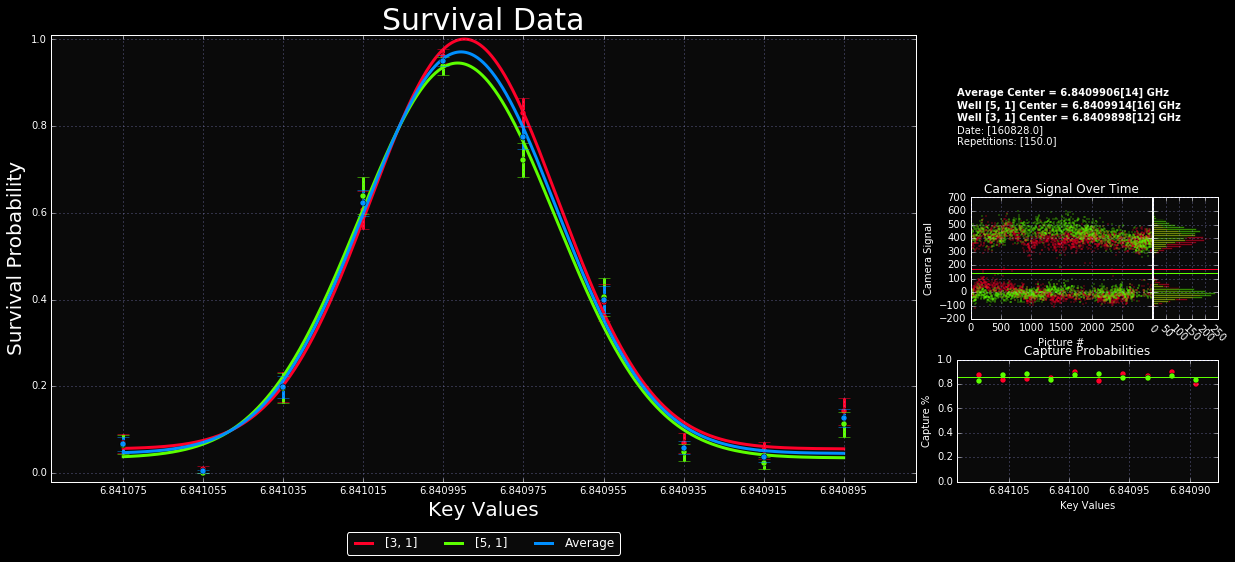

In [71]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']
# ################
# ### fit the data ###
#
data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
centerGuesses = []
widthGuess = np.std(data['Key']) / 2
# Get all the atoms
for atomInc in range(0, len(locs)):
    centerGuesses.append(data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                     .index(max(data[locs[atomInc]]['Survival Averages']))])
    # def gaussian(x, A1, x01, sig1, offset)
    data[locs[atomInc]]['fitValues'], \
        data[locs[atomInc]]['covValues'] = fit(gaussian, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                p0=[0.95, centerGuesses[atomInc], widthGuess, 0.05])
    data[locs[atomInc]]['fitData'] = gaussian(data['xForFit'], *data[locs[atomInc]]['fitValues']);
# fit the averaged data.
avgCenterGuess = np.mean(centerGuesses)
data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
    = fit(gaussian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
          p0=[0.95, avgCenterGuess, widthGuess, 0.05])
data['[Correlation Averages]']['fitData'] = gaussian(data['xForFit'], *data['[Correlation Averages]']['fitValues'])                                     

# ################ #########################
# ### Plotting ### #########################
# ################ #########################

# Make colormap. really only need len(locs) + 1 rgbs, but adding an extra makes the spacing of the colors
# on this colormap more sensible.
cmapRGB = mpl.cm.get_cmap('gist_rainbow', len(locs) + 2)
colormap = []
for colorInc in range(cmapRGB.N):
    colormap.append(mpl.colors.rgb2hex(cmapRGB(colorInc)[:3]))
# Setup grid
grid1 = mpl.gridspec.GridSpec(12, 16)
grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
gridLeft = mpl.gridspec.GridSpec(12, 16)
gridLeft.update(left=0.001, right=0.95, hspace=1000)
gridRight = mpl.gridspec.GridSpec(12, 16)
gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
# ### Main Plot
mainPlot = plt.subplot(grid1[:, :12])
# Plot Atoms
for atomInc in range(0, len(locs)):
    mainPlot.errorbar(data['Key'], data[locs[atomInc]]['Survival Averages'], yerr=data[locs[atomInc]]['Survival Errors'],
                      ls='', marker='o', color=colormap[atomInc], capsize=6, elinewidth=3)
    mainPlot.plot(data['xForFit'], data[locs[atomInc]]['fitData'], color=colormap[atomInc], label=locs[atomInc], 
                  linewidth=3)
# Plot Average
mainPlot.plot(data['xForFit'], data['[Correlation Averages]']['fitData'], color=colormap[len(locs)], 
              label='Average', linewidth=3)                                       
mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                  yerr=data['[Correlation Errors]']['Total average single atom survival'],
                  ls='', marker='o', color=colormap[len(locs)], capsize=6, elinewidth=3)
mainPlot.set_ylim({-0.02, 1.01})
mainPlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                  max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
mainPlot.set_xticks(data['Key'])
mainPlot.set_title("Survival Data", fontsize=30)
mainPlot.set_ylabel("Survival Probability", fontsize=20)
mainPlot.set_xlabel("Key Values", fontsize=20)
mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4)
mainPlot.grid("on")
# ### Capture Probabilities Plot
capturePlot = plt.subplot(grid1[8:12, 12:16])
for atomInc in range(len(locs)):
    capturePlot.plot(data['Key'], data[locs[atomInc]]['Loading Probabilities'], ls='', marker='o', 
                     color=colormap[atomInc])
    capturePlot.axhline(np.mean(data[locs[atomInc]]['Loading Probabilities']), color=colormap[atomInc])
capturePlot.set_ylim({0, 1})
capturePlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                  max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
capturePlot.set_xlabel("Key Values")
capturePlot.set_ylabel("Capture %")
capturePlot.set_title("Capture Probabilities")
capturePlot.grid("on")
# ### Count Series Plot
countDataPlot = plt.subplot(gridRight[4:8, 12:15])
for atomInc in range(len(locs)):
    countDataPlot.plot(data[locs[atomInc]]['Data Counts'], color=colormap[atomInc], ls='', marker='.', markersize=1)
    countDataPlot.axhline(data[locs[atomInc]]['Threshold'], color=colormap[atomInc])
countDataPlot.set_xlabel("Picture #")
countDataPlot.set_ylabel("Camera Signal")
countDataPlot.set_title("Camera Signal Over Time")
countDataPlot.grid("on")
ticksForVis = countDataPlot.xaxis.get_major_ticks()
ticksForVis[-1].label1.set_visible(False)
# Count Histogram Plot
countHistPlot = plt.subplot(gridLeft[4:8, 15:16], sharey=countDataPlot)
# countHistPlot = plt.subplot2grid((16, 16), (4, 15), rowspan=4, sharey=countDataPlot)
for atomInc in range(len(locs)):
    countHistPlot.hist(data[locs[atomInc]]["Data Counts"], 50, color=colormap[atomInc], orientation='horizontal',
                       alpha=1/len(locs))
    countHistPlot.axhline(data[locs[atomInc]]["Threshold"], color=colormap[atomInc])
ticks = countHistPlot.get_xticklabels()
for tickInc in range(len(ticks)):
    ticks[tickInc].set_rotation(-45)
plt.setp(countHistPlot.get_yticklabels(), visible=False)

# ### info plot
infoPlot = plt.subplot(grid1[0:4, 12:16])
infoPlot.axis("off")
infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
for atomInc in range(len(locs)):
    infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
              + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


## Generic Double-Gaussian Fit

[[6.840995, 6.840995]]
[[6.840995, 6.840995], [6.840995, 6.840995]]


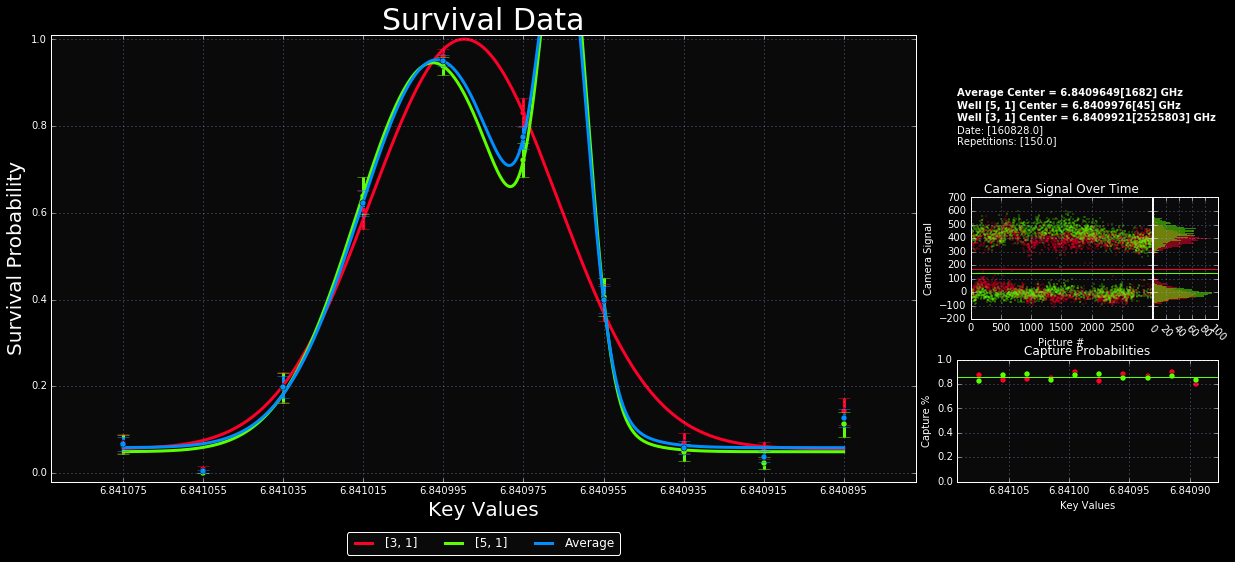

In [75]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 14)
# Atom locations
locs = ['[3, 1]', '[5, 1]']
# ################
# ### fit the data ###
#
data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
centerGuesses = [[]]
widthGuess = np.std(data['Key']) / 4
# Get all the atoms
for atomInc in range(0, len(locs)):
    guess1 = data['Key'][data[locs[atomInc]]['Survival Averages'] \
                                     .index(max(data[locs[atomInc]]['Survival Averages']))]
    dataWithoutPoissonian = []
    for dataInc in range(len(data[locs[atomInc]]['Survival Averages'])):
        dataWithoutPoissonian.append(data[locs[atomInc]]['Survival Averages'] 
                                     - poissonian(data['Key'][dataInc], guess1, 
                                                 2 * max(data[locs[atomInc]]['Survival Averages'])
                                                 / poissonian(guess1, guess1, 1)))
    dataWithoutPoissonian = dataWithoutPoissonian[0]
    guess2 = data['Key'][np.argmax(dataWithoutPoissonian)]
    if atomInc == 0:
        centerGuesses = [[guess1, guess2]]
    else:
        centerGuesses.append([guess1, guess2])
    # 
    print(centerGuesses)
    data[locs[atomInc]]['fitValues'], \
        data[locs[atomInc]]['covValues'] = fit(doubleGaussian, data['Key'], data[locs[atomInc]]['Survival Averages'], 
                                                p0=[0.8, centerGuesses[atomInc][0], widthGuess,
                                                    0.8, centerGuesses[atomInc][0], widthGuess, 0.05])
    data[locs[atomInc]]['fitData'] = doubleGaussian(data['xForFit'], *data[locs[atomInc]]['fitValues']);

# fit the averaged data.
avgCenterGuess1 = np.mean(centerGuesses[:][0])
avgCenterGuess2 = np.mean(centerGuesses[:][1])
data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
    = fit(doubleGaussian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
          p0=[0.8, avgCenterGuess1, widthGuess, 0.8, avgCenterGuess2, widthGuess, 0.05])
data['[Correlation Averages]']['fitData'] = doubleGaussian(data['xForFit'], 
                                                           *data['[Correlation Averages]']['fitValues'])                                     

# ################ #########################
# ### Plotting ### #########################
# ################ #########################

# Make colormap. really only need len(locs) + 1 rgbs, but adding an extra makes the spacing of the colors
# on this colormap more sensible.
cmapRGB = mpl.cm.get_cmap('gist_rainbow', len(locs) + 2)
colormap = []
for colorInc in range(cmapRGB.N):
    colormap.append(mpl.colors.rgb2hex(cmapRGB(colorInc)[:3]))
# Setup grid
grid1 = mpl.gridspec.GridSpec(12, 16)
grid1.update(left=0.05, right=0.95, wspace=1.2, hspace=1000)
gridLeft = mpl.gridspec.GridSpec(12, 16)
gridLeft.update(left=0.001, right=0.95, hspace=1000)
gridRight = mpl.gridspec.GridSpec(12, 16)
gridRight.update(left=0.2, right=0.946, wspace=0, hspace=1000)
# ### Main Plot
mainPlot = plt.subplot(grid1[:, :12])
# Plot Atoms
for atomInc in range(0, len(locs)):
    mainPlot.errorbar(data['Key'], data[locs[atomInc]]['Survival Averages'], yerr=data[locs[atomInc]]['Survival Errors'],
                      ls='', marker='o', color=colormap[atomInc], capsize=6, elinewidth=3)
    mainPlot.plot(data['xForFit'], data[locs[atomInc]]['fitData'], color=colormap[atomInc], label=locs[atomInc], 
                  linewidth=3)
# Plot Average
mainPlot.plot(data['xForFit'], data['[Correlation Averages]']['fitData'], color=colormap[len(locs)], 
              label='Average', linewidth=3)                                       
mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                  yerr=data['[Correlation Errors]']['Total average single atom survival'],
                  ls='', marker='o', color=colormap[len(locs)], capsize=6, elinewidth=3)
mainPlot.set_ylim({-0.02, 1.01})
mainPlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                  max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
mainPlot.set_xticks(data['Key'])
mainPlot.set_title("Survival Data", fontsize=30)
mainPlot.set_ylabel("Survival Probability", fontsize=20)
mainPlot.set_xlabel("Key Values", fontsize=20)
mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4)
mainPlot.grid("on")
# ### Capture Probabilities Plot
capturePlot = plt.subplot(grid1[8:12, 12:16])
for atomInc in range(len(locs)):
    capturePlot.plot(data['Key'], data[locs[atomInc]]['Loading Probabilities'], ls='', marker='o', 
                     color=colormap[atomInc])
    capturePlot.axhline(np.mean(data[locs[atomInc]]['Loading Probabilities']), color=colormap[atomInc])
capturePlot.set_ylim({0, 1})
capturePlot.set_xlim({min(data['Key']) - (max(data['Key']) - min(data['Key'])) / len(data['Key']), 
                  max(data['Key']) + (max(data['Key']) - min(data['Key'])) / len(data['Key'])})
capturePlot.set_xlabel("Key Values")
capturePlot.set_ylabel("Capture %")
capturePlot.set_title("Capture Probabilities")
capturePlot.grid("on")
# ### Count Series Plot
countDataPlot = plt.subplot(gridRight[4:8, 12:15])
for atomInc in range(len(locs)):
    countDataPlot.plot(data[locs[atomInc]]['Data Counts'], color=colormap[atomInc], ls='', marker='.', markersize=1)
    countDataPlot.axhline(data[locs[atomInc]]['Threshold'], color=colormap[atomInc])
countDataPlot.set_xlabel("Picture #")
countDataPlot.set_ylabel("Camera Signal")
countDataPlot.set_title("Camera Signal Over Time")
countDataPlot.grid("on")
ticksForVis = countDataPlot.xaxis.get_major_ticks()
ticksForVis[-1].label1.set_visible(False)
# Count Histogram Plot
countHistPlot = plt.subplot(gridLeft[4:8, 15:16], sharey=countDataPlot)
for atomInc in range(len(locs)):
    countHistPlot.hist(data[locs[atomInc]]["Data Counts"], bins=np.arange(min(data[locs[atomInc]]["Data Counts"]),
                                                                           max(data[locs[atomInc]]["Data Counts"]) + 5, 5),
                       color=colormap[atomInc], orientation='horizontal', lw=0, alpha=1/len(locs))
    countHistPlot.axhline(data[locs[atomInc]]["Threshold"], color=colormap[atomInc])
ticks = countHistPlot.get_xticklabels()
for tickInc in range(len(ticks)):
    ticks[tickInc].set_rotation(-45)
plt.setp(countHistPlot.get_yticklabels(), visible=False)

# ### info plot
infoPlot = plt.subplot(grid1[0:4, 12:16])
infoPlot.axis("off")
infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
infoPlot.text(0, 0.2, "Date: " + str(data['Date']))
for atomInc in range(len(locs)):
    infoPlot.text(0,0.3 + 0.1 * atomInc,'Well ' + locs[atomInc] + ' Center = ' + "{:.7f}".format(data[locs[atomInc]]['fitValues'][1]) + "[" 
                  + "{:.0f}".format(10**7*np.sqrt(data[locs[atomInc]]['covValues'][1][1])) + "] GHz", fontweight='bold')
infoPlot.text(0,0.3 + 0.1 * len(locs),'Average Center = ' + "{:.7f}".format(data['[Correlation Averages]']['fitValues'][1]) + "[" 
              + "{:.0f}".format(10**7 * np.sqrt(data['[Correlation Averages]']['covValues'][1][1])) + "] GHz", fontweight='bold');


## Generic Decohering Sine Fit

## Generic Triple-Gaussian Fit

## Generic Lorentzian Fit

C:\Users\Mark\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


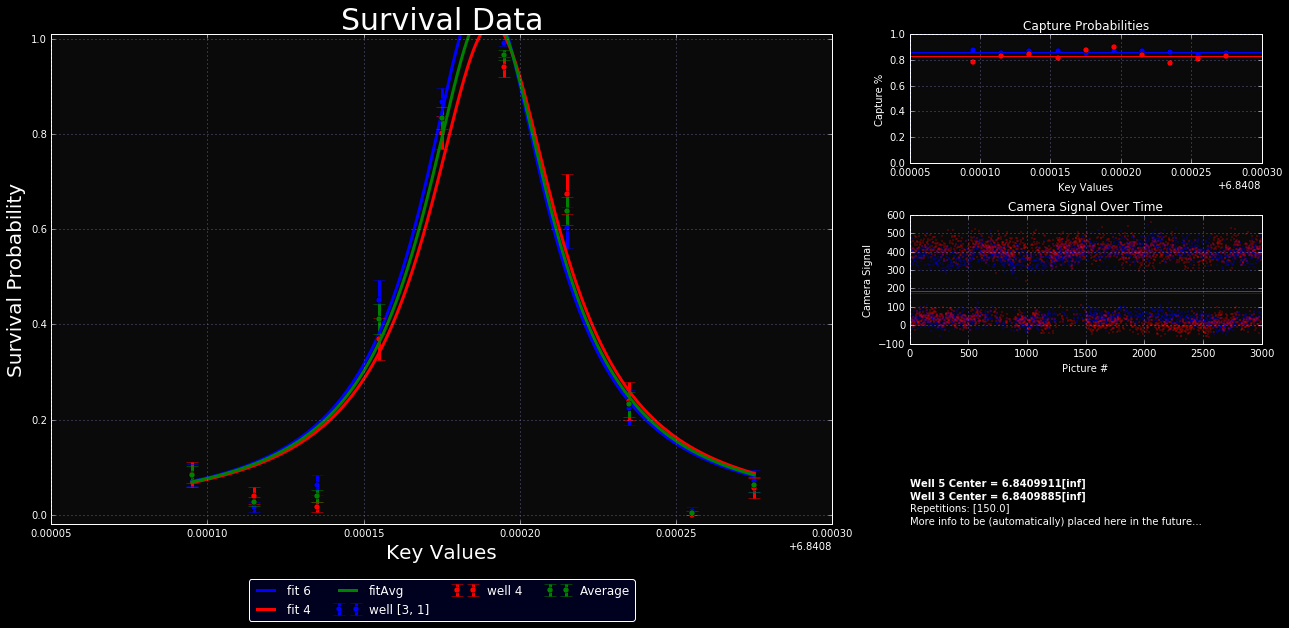

In [10]:
# locals for convenience
filename = "Carrier_Calibration_Top_Vert" # shouldn't include run number.
data = importData(date, filename, 12) # stands for "data from run 11"
locs = ['[3, 1]', '[5, 1]']
# fit
data['xForFit'] = np.linspace(min(data['Key']), max(data['Key']), 1000)
likelyCenter1 = data['Key'][data[locs[0]]['Survival Averages'].index(max(data[locs[0]]['Survival Averages']))]
widthGuess = np.std(data['Key']) # assumes downward facing.
# def sinc_squared(x, A, center, scale, offset):
data[locs[0]]['fitValues'], data[locs[0]]['covValues'] = fit(lorentzian, data['Key'], 
                                                             data[locs[0]]['Survival Averages'], 
                                                             p0=[0.95, likelyCenter1, widthGuess, 0.05])
data[locs[0]]['fitData'] = lorentzian(data['xForFit'], *data[locs[0]]['fitValues']);

likelyCenter2 = data['Key'][data[locs[1]]['Survival Averages'].index(max(data[locs[1]]['Survival Averages']))]
data[locs[1]]['fitValues'], data[locs[1]]['covValues']  = fit(lorentzian, data['Key'], 
                                                              data[locs[1]]['Survival Averages'],
                                        p0=[0.95, likelyCenter2, widthGuess, 0.05])
data[locs[1]]['fitData'] = lorentzian(data['xForFit'], *data[locs[1]]['fitValues'])
likelyCenterAvg = (likelyCenter2 + likelyCenter1) / 2
data['[Correlation Averages]']['fitValues'], data['[Correlation Averages]']['covValues'] \
    = fit(lorentzian, data['Key'], data['[Correlation Averages]']['Total average single atom survival'],
          p0=[0.95, likelyCenterAvg, widthGuess, 0.05])
data['[Correlation Averages]']['fitData'] = lorentzian(data['xForFit'], *data['[Correlation Averages]']['fitValues'])
                                       
# Main Plot
mainPlot = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
mainPlot.errorbar(data['Key'], data[locs[0]]['Survival Averages'], yerr=data[locs[0]]['Survival Errors'],
                  ls='', marker='o', label="well " + locs[0], color='b', capsize=6,
                  elinewidth=3)
mainPlot.plot(data['xForFit'], data[locs[0]]['fitData'], color='b', label='fit 6', linewidth=3)
#
mainPlot.errorbar(data['Key'], data[locs[1]]['Survival Averages'], yerr=data[locs[1]]['Survival Errors'],
                  ls='', marker='o', label="well 4", color='r', capsize=6, elinewidth=3)
mainPlot.plot(data['xForFit'], data[locs[1]]['fitData'], color='r', label='fit 4', linewidth=3)
#
mainPlot.plot(data['xForFit'], data['[Correlation Averages]']['fitData'], color='g', label='fitAvg', linewidth=3)                                       
mainPlot.errorbar(data['Key'], data['[Correlation Averages]']['Total average single atom survival'], 
                  yerr=data['[Correlation Errors]']['Total average single atom survival'],
                  ls='', marker='o', label="Average", color='g', capsize=6, elinewidth=3)

mainPlot.set_ylim({-0.02, 1.01});
mainPlot.set_title("Survival Data", fontsize=30);
mainPlot.set_ylabel("Survival Probability", fontsize=20);
mainPlot.set_xlabel("Key Values", fontsize=20);
mainPlot.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1), fancybox=True, ncol=4);
mainPlot.grid("on")
# Capture Probabilities Plot
capturePlot = plt.subplot2grid((3, 3), (0, 2))
capturePlot.plot(data['Key'], data[locs[0]]['Loading Probabilities'], ls='', marker='o', color='b')
capturePlot.axhline(np.mean(data[locs[0]]['Loading Probabilities']), color='b')
capturePlot.plot(data['Key'], data[locs[1]]['Loading Probabilities'], ls='', marker='o', color='r')
capturePlot.axhline(np.mean(data[locs[1]]['Loading Probabilities']), color='r')
capturePlot.set_ylim({0, 1})
capturePlot.set_xlabel("Key Values")
capturePlot.set_ylabel("Capture %")
capturePlot.set_title("Capture Probabilities")
capturePlot.grid("on")
# Count Series Plot
countDataPlot = plt.subplot2grid((3, 3), (1, 2))
countDataPlot.plot(data[locs[0]]['Data Counts'], 'b', ls='', marker='.', markersize=1)
countDataPlot.axhline(data[locs[0]]['Threshold'], color='b')
countDataPlot.plot(data[locs[1]]['Data Counts'], 'r', ls='', marker='.', markersize=1)
countDataPlot.axhline(data[locs[1]]['Threshold'], color='r')

countDataPlot.set_xlabel("Picture #")
countDataPlot.set_ylabel("Camera Signal")
countDataPlot.set_title("Camera Signal Over Time")
countDataPlot.grid("on")
# info plot
infoPlot = plt.subplot2grid((3,3), (2,2))
infoPlot.axis("off")
infoPlot.text(0,0, "More info to be (automatically) placed here in the future...")
infoPlot.text(0,0.1,"Repetitions: " + str(data['Repetitions']))
infoPlot.text(0,0.2,"Well 3 Center = " + "{:.7f}".format(data[locs[0]]['fitValues'][1]) + "[" 
              + "{:.0f}".format(10**7*np.sqrt(data[locs[0]]['covValues'][1][1])) + "]", fontweight='bold')
infoPlot.text(0,0.3,"Well 5 Center = " + "{:.7f}".format(data[locs[1]]['fitValues'][1]) + "[" 
              + "{:.0f}".format(10**7*np.sqrt(data[locs[1]]['covValues'][1][1])) + "]", fontweight='bold')
plt.tight_layout();

# Specific Multi-Atom Analysis

## Tunneling Bias Scan

## Tunneling Time Trace

# Specific Single-Atom Data Analysis

## Carrier Calibration

## Microwave Calibration

## Sideband Spectroscopy

## Ramsey Time Trace

## Piezo Scan